<a id='top'></a>
# OutSystems Machine Learning Challenge

<br>
The OutLending is a peer-to-peer lending company that directly connects borrowers and potential lenders/investors. For this exercise you will build a classification model to predict whether a loan provided by OutLending is likely to default.
<br>

For this exercise, you will use data from the OutLending to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default and present it to our senior management team.
<br>


## Outline:
1. <a href='#analyse'>Analyse Dataset</a>
    <br>1.1. <a href='#distribution'>Distribution Plot Analysis</a>
    <br>1.2. <a href='#risk'>Risk Ratio Analysis (Categorical)</a>
2. <a href='#establish'>Establishing a Baseline</a>
3. <a href='#performance'>Performance Metrics</a>
4. <a href='#feature'>Feature Engineering & Selection</a>
5. <a href='#balancing'>Balancing Dataset</a>
    <br>5.1 <a href='#under'>Under Sampling</a>
    <br>5.2 <a href='#unbalanced'>Unbalanced</a>
    <br>5.3 <a href='#over'>Over Sampling</a>
6. <a href='#build'>Build Models</a>
7. <a href='#train'>Train Models</a>
    <br>7.1. <a href='#precision'>Precision Micro</a>
    <br>7.2. <a href='#cost'>Cost Scorer</a>
8. <a href='#application'>OutLending Application</a>



In [4]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Binarizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle
from IPython.display import Image

#had to write into a file that can be imported for it be saveable with pickle
from cost_scorer.cost_scorer import cost_scorer

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
path = 'OUTLENDING_VARIABLES.csv'


In [3]:
#convert categorical columns to object type
#note that 'EMP_LENGHT_NUM' gets converted to categorical, since there are only 12 possible values
def identify_categorical_features(df, verbose=False):
    '''identifies columns with few possible values (less than 5), and converts them to object type.
    All object type features will later be one hot encoded (i.e dummies)'''
    for column in df.columns:
        if len(df[column].unique()) < 15:
            df[column] = df[column].astype(object)
    if verbose == True:
        print(df.dtypes)
    return df

def load_dataset(path, index_col=0, verbose=False):
    df = pd.read_csv(path, index_col = index_col)
    df = identify_categorical_features(df, verbose=verbose)
    if verbose == True:
            df.info()
            print(df.head())
    return df

<a id='analyse'></a>
# 1. Analyse Dataset
<a href='#top'>back to top</a>

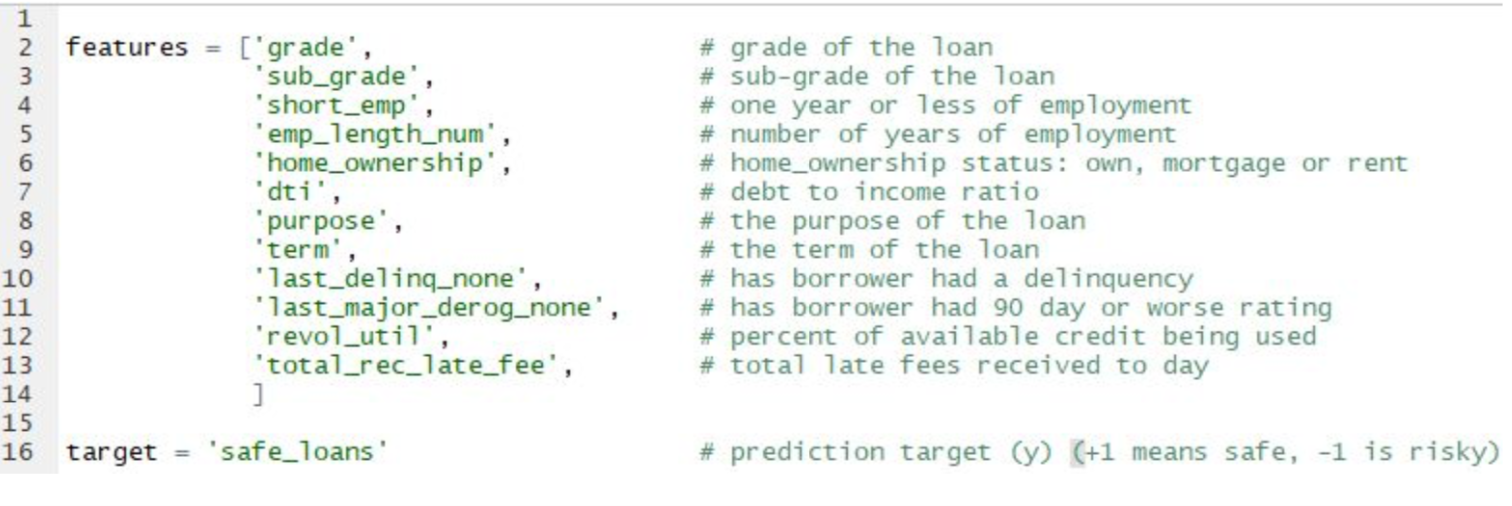

In [3]:
#Features
Image(filename='features.png')

In [4]:
df_analysis = load_dataset(path, index_col=0, verbose=True)

GRADE                     object
SUB_GRADE                 object
SHORT_EMP                 object
EMP_LENGTH_NUM            object
HOME_OWNERSHIP            object
DTI                      float64
PURPOSE                   object
TERM                      object
LAST_DELINQ_NONE          object
LAST_MAJOR_DEROG_NONE     object
REVOL_UTIL               float64
TOTAL_REC_LATE_FEE       float64
BAD_LOANS                 object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 122607 entries, 0 to 122606
Data columns (total 13 columns):
GRADE                    122607 non-null object
SUB_GRADE                122607 non-null object
SHORT_EMP                122607 non-null object
EMP_LENGTH_NUM           122607 non-null object
HOME_OWNERSHIP           122607 non-null object
DTI                      122607 non-null float64
PURPOSE                  122607 non-null object
TERM                     122607 non-null object
LAST_DELINQ_NONE         122607 non-null object
LAST_MAJOR_DE

In [5]:
df_analysis.isnull().sum()

GRADE                    0
SUB_GRADE                0
SHORT_EMP                0
EMP_LENGTH_NUM           0
HOME_OWNERSHIP           0
DTI                      0
PURPOSE                  0
TERM                     0
LAST_DELINQ_NONE         0
LAST_MAJOR_DEROG_NONE    0
REVOL_UTIL               0
TOTAL_REC_LATE_FEE       0
BAD_LOANS                0
dtype: int64

<a id='distribution'></a>
## 1.1. Distribution Plot Analysis
<a href='#top'>back to top</a>

We will plot the risky (BAD_LOANS = 1) against the safe (BAD_LOANS = 0) loans for each features to find out if certain features help us more easily distinguish between the two types of loans. Not only will this help us to better understand the dataset, it might also give us some ideas for feature engineering later on.

In [6]:
def plot_distributions(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    continuous_columns = df.select_dtypes(exclude=['object']).columns
    
    for continuous in continuous_columns:
        plt.figure(figsize=(8,5))
        con = sns.distplot(a=df.loc[df['BAD_LOANS'] == 1][continuous], kde=True, label='Risky', hist_kws=dict(alpha=1))
        con = sns.distplot(a=df.loc[df['BAD_LOANS'] == 0][continuous], kde=True, label='Safe', hist_kws=dict(alpha=0.5))
        plt.legend()
        plt.show()
         
        plt.figure(figsize=(8,5))
        box = sns.boxplot(x='BAD_LOANS', y=continuous, data=df, order=[1, 0])
        plt.show()
 
    for categorical in categorical_columns:
        plt.figure(figsize=(8,5))
        cat = sns.countplot(x=categorical, hue='BAD_LOANS', data=df)
        plt.xticks(rotation=90)
        plt.show()
        

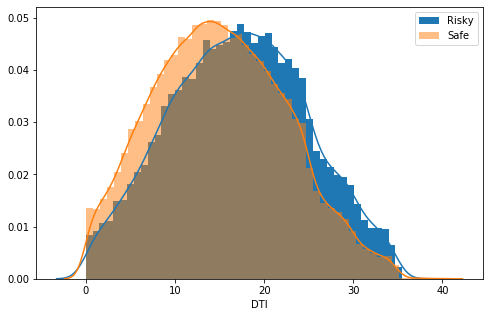

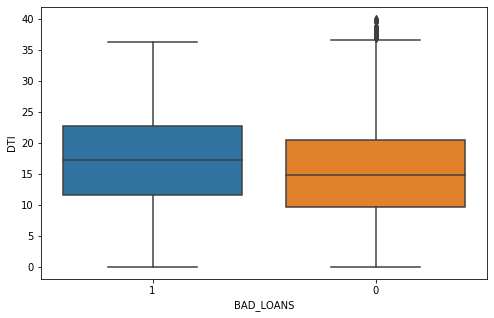

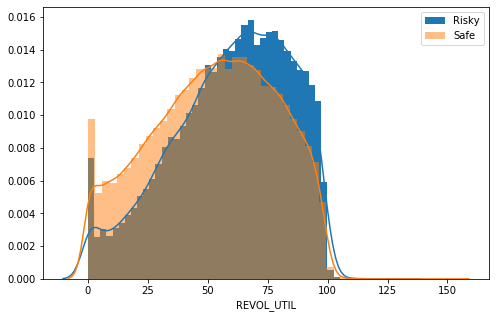

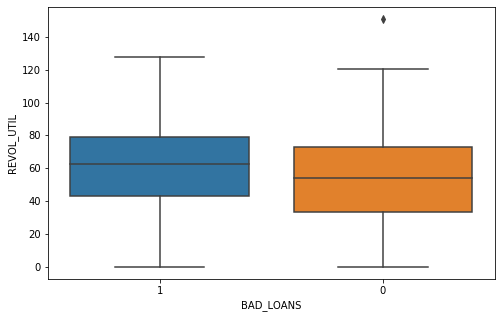

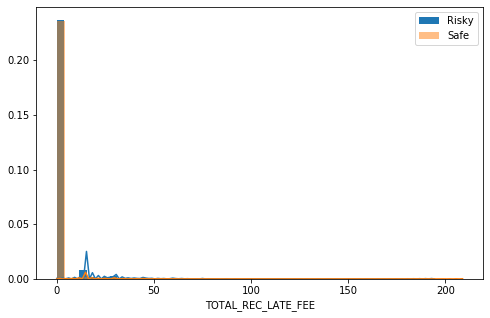

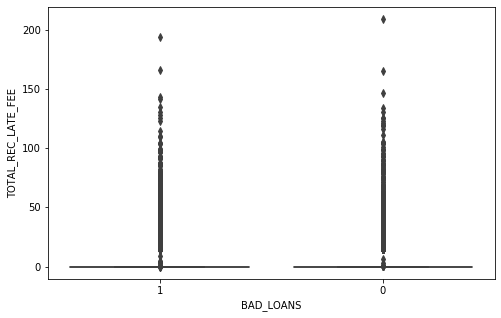

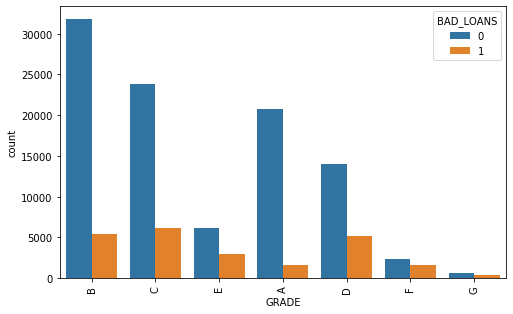

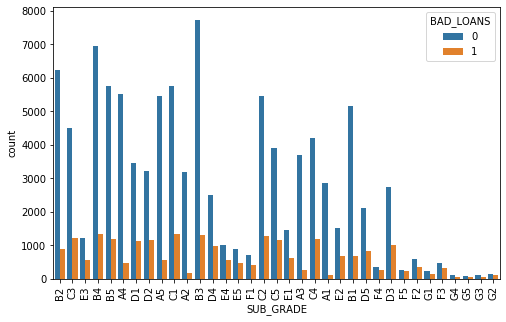

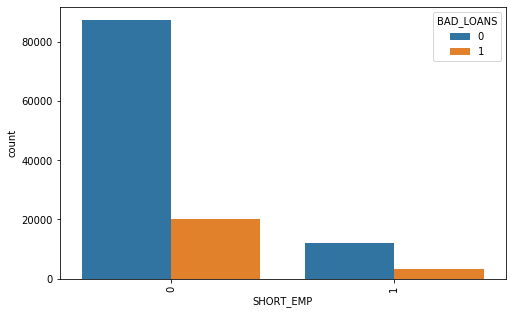

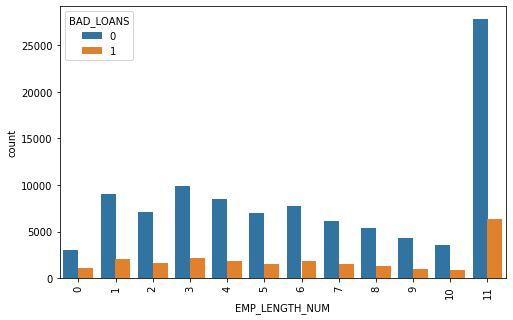

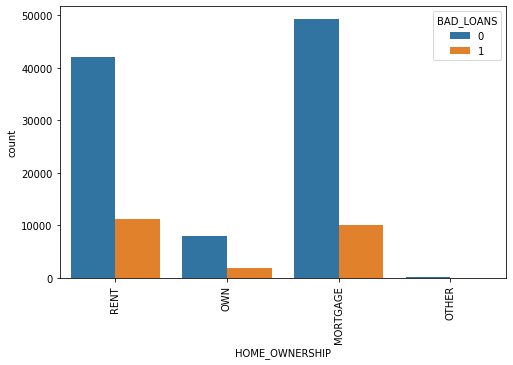

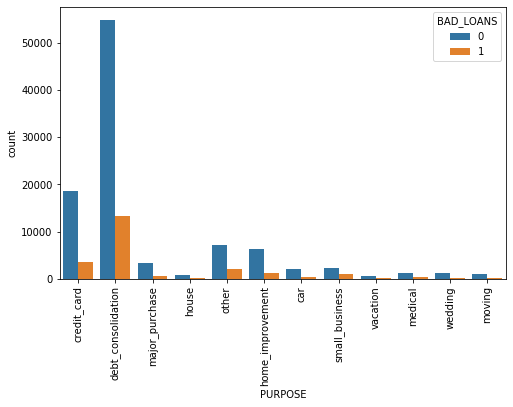

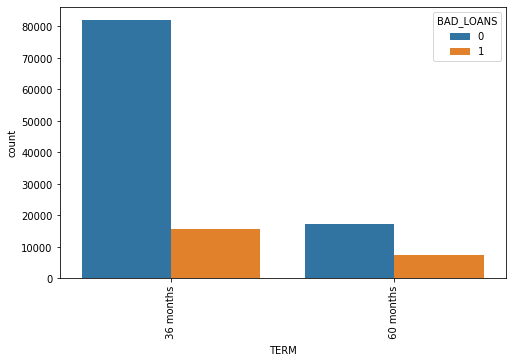

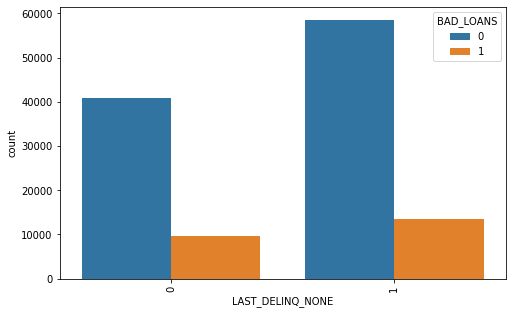

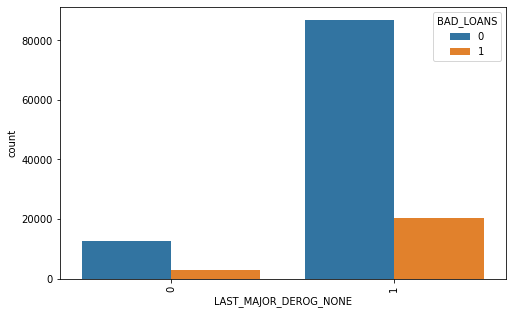

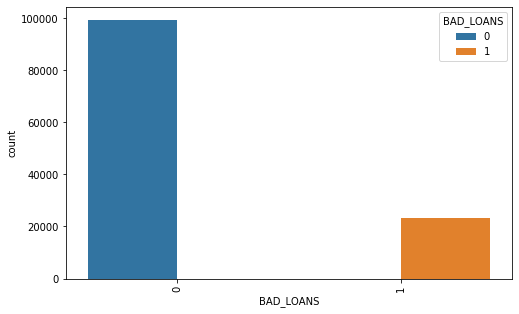

In [7]:
plot_distributions(df_analysis)


#### TARGET FEATURE 

**Bad Loans** (last graph): *Was the loan safe of risky.* <br> The target feature shows a clear imbalance in the dataset, with around 100,000 safe loans and 20,000 risky loans. Two balancing technques will be applied to try and improve the classification abilities of the models; Over sampling the dataset using *Synthetic Minority Oversampling Technique (SMOTE)*, and under sampling by reducing the dataset to even the balance between safe and risky loans.


#### CONTINUOUS FEATURES


1. **DTI**: *Debt to Income ratio.* <br> No major difference in distribution, although risky loans have a higher average Debt To Income ratio (DTI) than safe loans (suprisingly). It is also important to note the outliers for the safe loans indicate that a DTI higher than 36% guaranteers a safe loan, as far as this dataset is concerned. This feature could be turned into a categorical feautre by rounding each value to the nearest 10%.


2. **Revol Util**: *Percent of available credit being used.* <br> Higher percentages of available credit used can be associated with higher probabilities of defaulting on loans, although the difference doesn't seem large enough to state this as a definitive rule. Note the outliers for safe loans; they have the highest percent of available credit being used. It could be useful to further study the DTI for those loans; a low DTI could indicate the borrower has lots of collateral. This feature could be turned into a categorical feature by rounding each value to the nearest 10% (e.g 17% becomes 20%, 32% becomes 30%).


3. **Total Rec Late Fee**: *Total late fees received to day.* <br> Most borrowers have never received late fees, and the amount of late fees do not help us distinguish risky loans from safe ones. One solution could be to binarize this feature with 0: *not late fees*, and 1: *late fees*. It is important to note that this feature holds the 'total late fees received to day', which can be interpreted as the total amount of late fees received by the borrower, or the total amount of late fees received by the bank from the borrower. In the latter case, we could assume that 'risky' borrowers have received alot of late fees, but simply have not paid them yet, meaning that they are not registered in this feature.


#### CATEGORICAL FEATURES


4. **Grade** & **Sub Grade**: *Grade and Sub Grade of the loan.* <br> At first glance, lower grades and sub grades seem to have higher proportional ratios of bad loans, meaning that lower grade/sub grade loans have higher risk associated with them. Risk ratios for each grade and sub grade will be calculated.


5. **Short Emp** & **Emp Length Num**: *Amount of years of employment.* <br> The informatio of Short Emp is also defined in Emp Length Num, so we can drop Short Emp. Again, it is important to look at risk ratios associated with each year of employment. Depending on the risk ratios associated with each year of employment, we could simplify this feature by reducing the number of possible values (e.g 0: years, 1: 1-9 years, 2: 9+ years).


6. **Home Ownership**: *Home ownership status: Own, Rent, or Mortgage.* <br> Most borrowers either rent or pay mortage for their housing. One possible explanation for the minority of home owners is that they can use more 'traditional' channels to borrow money (e.g bank, venture capital) since they have more collateral. As with all categorical features, it is important to analyse the risk ratio associated with each possible value for this feature.


7. **Purpose**: *The purpose of the loan.* <br> The vast majority of issued loans are for debt consolidation and credit card debt, two categories often associated with high-risk borrowers. Risk ratios for each category need to be calculated.


8. **Term**: *The term of the loan.*  <br> Most loans are short term (3 years), however long term loans (5 years) have a higher rate of risky loans.


9. **Last Delinq**: *Has the borrower had a delinquency.* <br> Borrowers with previous delinquencies have a higher chance of defaulting on their loans.


10. **Last Major Derog None**: *Has borrower had 90 day or worse rating.* <br> most borrowers (>80%) have had a  90 day or worse rating, meaning they have been late on previous payments. Appropriate risk ratios need to be calculated, but it is fairly obvious that borrowers with 90 or worse rating have a higher chance to default on their loans.



<a id='risk'></a>
## 1.2. Risk Ratio Analysis (categorical features)
<a href='#top'>back to top</a>

Ratios allow us to do two things:
1. Create an ordinal category feature with appropriate importance for earch possible value.
2. Use each feature's risk ratio to create a cummulative risk ratio.

In [9]:
def calculate_ratio(df, feature, target_feature):
    risk_count_df = df[feature].loc[df[target_feature] == 1].value_counts()
    safe_count_df = df[feature].loc[df[target_feature] == 0].value_counts()

    risk_dict = {}
    for idx in risk_count_df.index:
        try:
            risk_dict[idx] = np.round((risk_count_df.loc[idx] / (risk_count_df.loc[idx] + safe_count_df.loc[idx])) * 100, 2)
        except:
            risk_dict[idx] = 100
    return risk_dict

def calculate_odd_ratio(df, feature, target_feature):
    risk_count_df = df[feature].loc[df[target_feature] == 1].value_counts()
    safe_count_df = df[feature].loc[df[target_feature] == 0].value_counts()


    whole_df = pd.concat([risk_count_df, safe_count_df], axis=1, sort=False)
    whole_df.columns = ['risky', 'safe']
    risk_dict = {}
    for idx in whole_df.index:
        num = whole_df.loc[idx, 'risky'] / whole_df.loc[idx, 'safe']
        denom = whole_df.loc[idx, 'risky'] / (whole_df['risky'].sum() - whole_df.loc[idx, 'risky'])
        odds = num / denom
        risk_dict[idx] = np.round(odds, 2) #np.round(np.log(odds), 2)
    return risk_dict

In [10]:
def create_odd_ratio_features(df, target, plot=False):
    original_features = df.loc[:, df.columns != target].columns
    for feature in original_features:
        feature_type = df[feature].dtype
        odds_ratio = calculate_odd_ratio(df=df, feature=feature, target_feature=target)
        df['%s_ODDS'%feature] = df[feature].astype(feature_type).map(odds_ratio)
        dict_df = pd.DataFrame.from_dict(odds_ratio, orient='index', columns=[feature])
        dict_df = dict_df.sort_values(by=[feature], ascending=False)
        if plot == True:
            print(dict_df.head(10))
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
            con = sns.countplot(x=feature, hue='BAD_LOANS', data=df, ax=axes[0])
            con_ = sns.barplot(x=dict_df.index, y=dict_df[feature], ax=axes[1])
            con.set(xlabel='%s'%feature, ylabel='%s Countplot'%feature)
            con_.set(xlabel='%s'%feature, ylabel='%s Odds Ratio'%feature)
            axes[0].tick_params('x', labelrotation=90)
            axes[1].tick_params('x', labelrotation=90)
            fig.show()
            plt.show()     
    df = df.drop(original_features, axis=1)
    return df

def create_precent_ratio_features(df, target, plot=False):
    original_features = df.loc[:, df.columns != target].columns
    for feature in original_features:
        feature_type = df[feature].dtype
        odds_ratio = calculate_ratio(df=df, feature=feature, target_feature=target)
        df['%s_RISK'%feature] = df[feature].astype(feature_type).map(odds_ratio)
        dict_df = pd.DataFrame.from_dict(odds_ratio, orient='index', columns=[feature])
        dict_df = dict_df.sort_values(by=[feature], ascending=False)
        if plot == True:
            print(dict_df.head(10))
            
            plt.figure(figsize=(8,5))
            con = sns.barplot(x=dict_df.index, y=dict_df[feature])
            con.set(xlabel='%s'%feature, ylabel='%s Odds Ratio'%feature)
            plt.xticks(rotation=90)
            plt.show()
    df = df.drop(original_features, axis=1)
    return df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


   GRADE
G  34.70
F   9.09
E   3.32
D   1.28
A   1.04
C   0.71
B   0.56


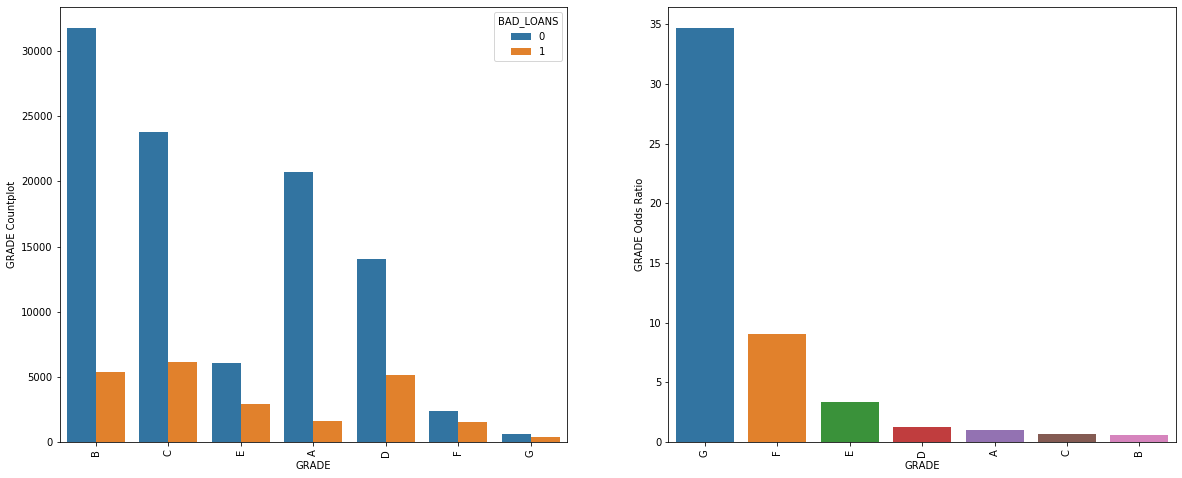

    SUB_GRADE
G5     256.62
G4     228.70
G3     224.14
G2     163.48
G1     104.55
F5      84.28
F4      64.26
F3      49.76
F2      38.66
F1      32.54


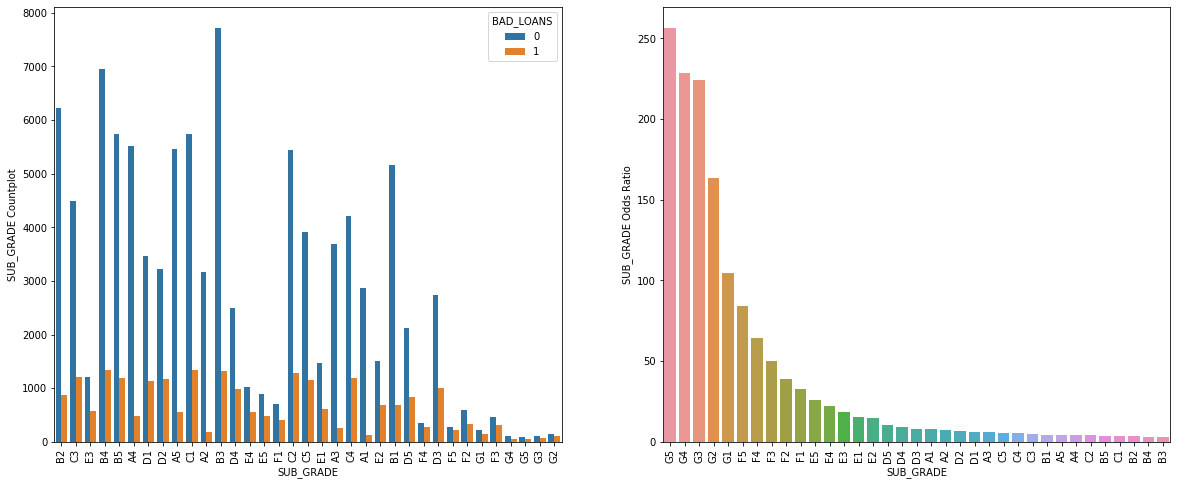

   SHORT_EMP
1       1.67
0       0.04


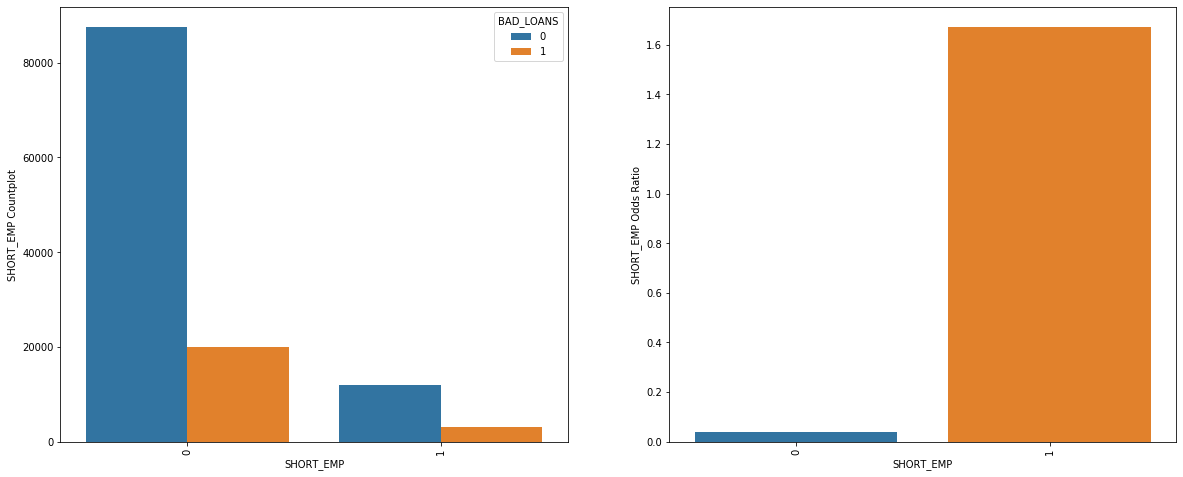

    EMP_LENGTH_NUM
0             7.38
10            6.20
9             5.09
8             4.05
7             3.54
5             3.09
2             3.04
6             2.75
4             2.52
1             2.34


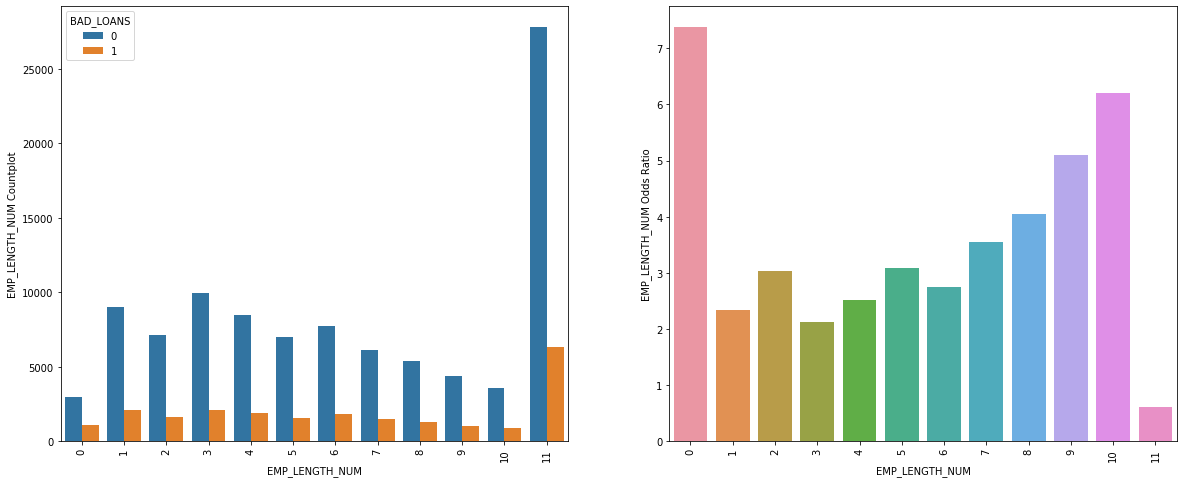

          HOME_OWNERSHIP
OTHER             167.46
OWN                 2.65
RENT                0.29
MORTGAGE            0.27


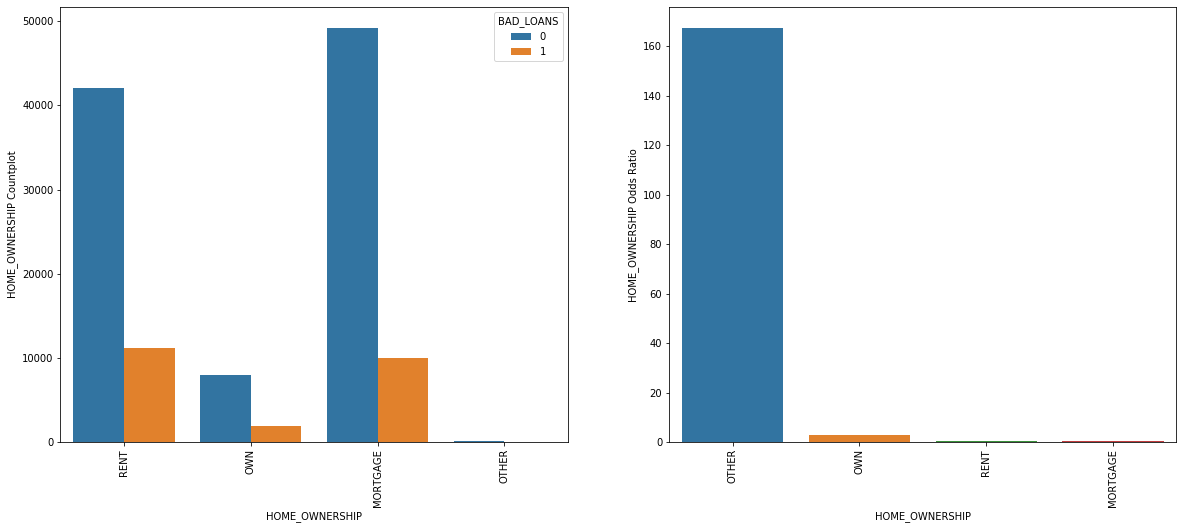

                  PURPOSE
vacation            32.89
house               27.88
moving              24.57
medical             17.90
wedding             17.71
car                 11.06
small_business       9.99
major_purchase       6.79
home_improvement     3.46
other                2.99


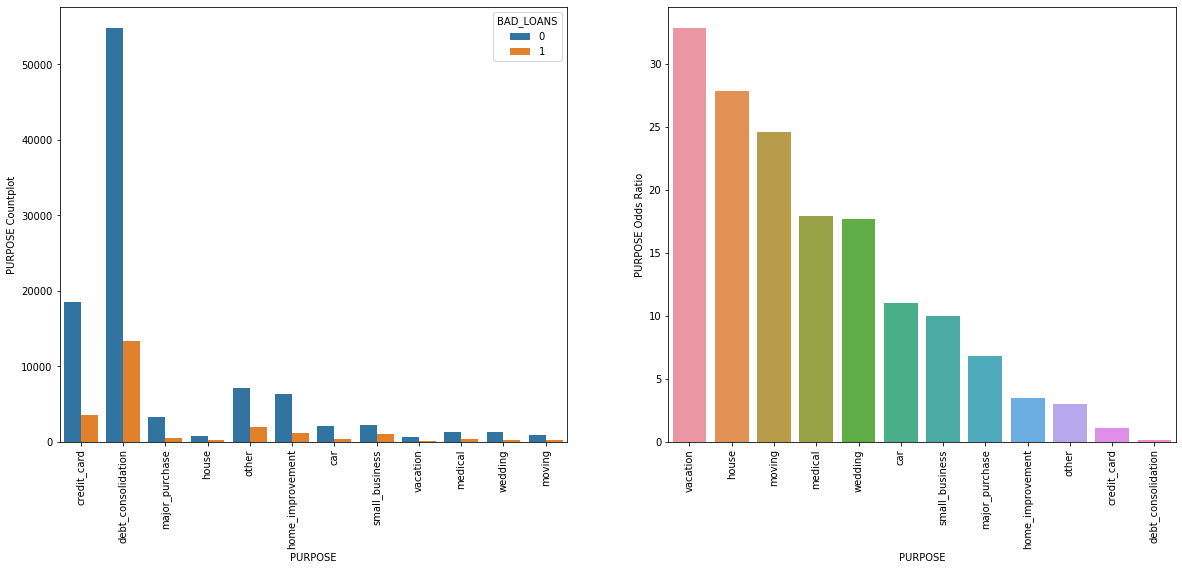

            TERM
 60 months  0.90
 36 months  0.09


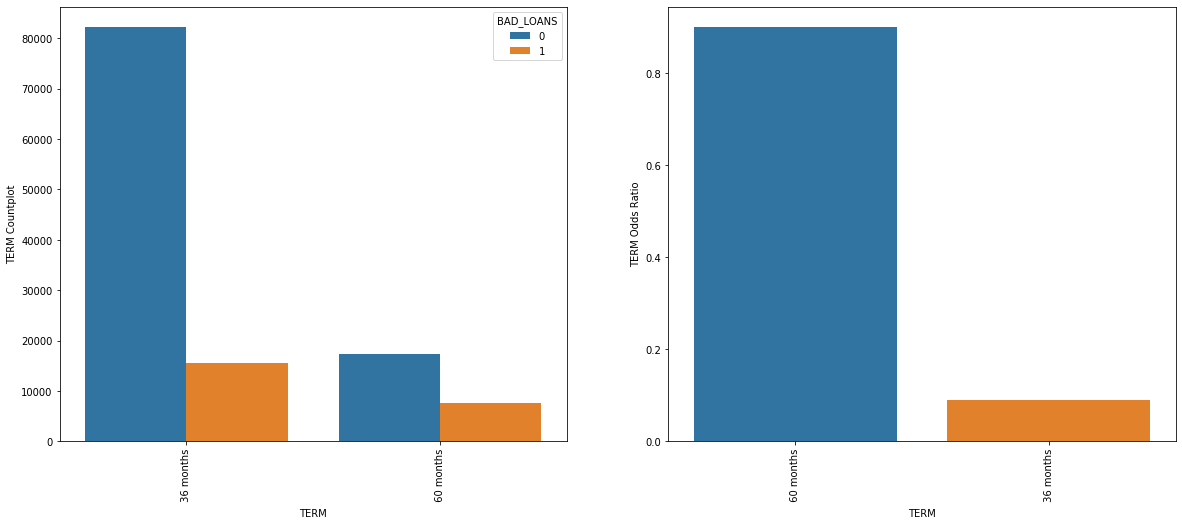

   LAST_DELINQ_NONE
0              0.33
1              0.16


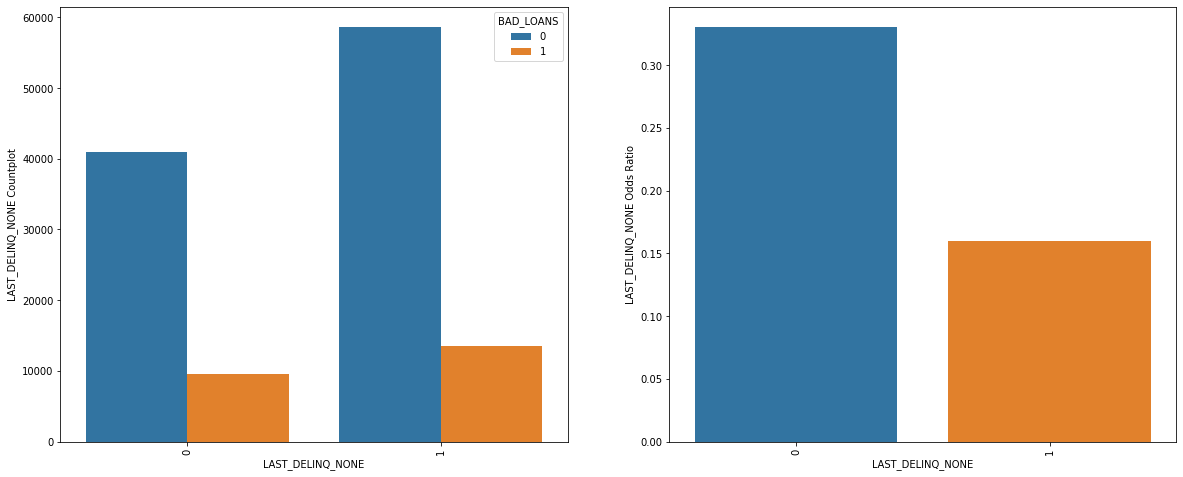

   LAST_MAJOR_DEROG_NONE
0                   1.61
1                   0.03


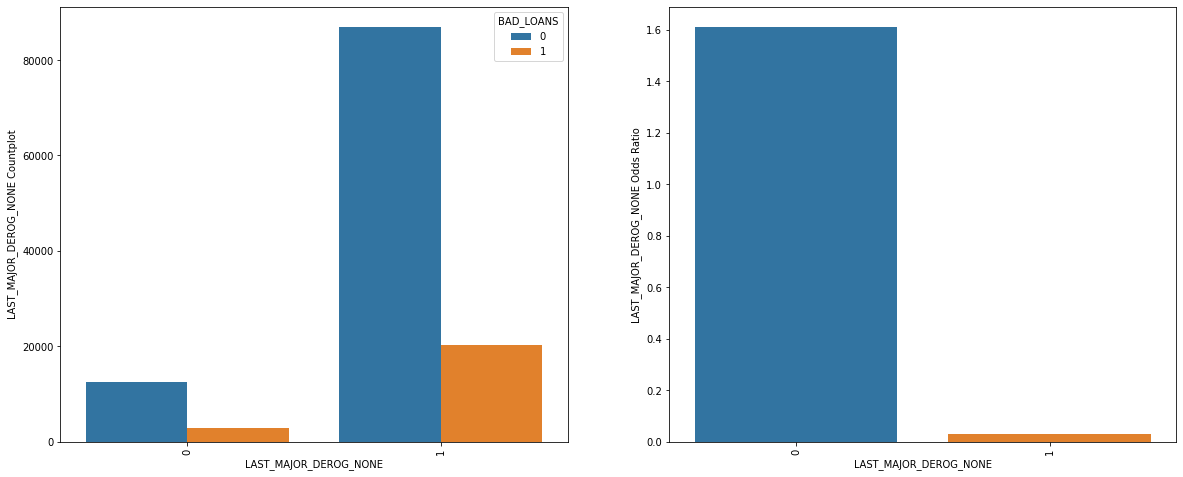

In [11]:
categorical_risk_ratio_df = create_odd_ratio_features(df=df_analysis.select_dtypes(include=['object']), target='BAD_LOANS', plot=True)


1. **Grade** & **Sub Grade**: <br> Lower grades have much higher risk associated to them.


2. **Short Emp**: <br> Short Emp is a good indicator as to whether a loan is risky or safe. Borrowers with 'one year or less' of employment (short emp=1) tend to be riskier.


3. **Emp Length Num**: <br> Again, less than one year of employment is associated with a higher risk. Surprisingly, 9 and 10 years are also associated with a relatively high risk. 10+ years employment is an indicator of safety for loans.


4. **Home Ownership**: <br> 'Other' have a very high association with risk.


5. **Purpose**: <br> Contrary to the previous assumption, debt consolidation and credit card repayment are not strongly associated with risky loans. 


6. **Term**: <br> Long term loans (5 years) have a tendency to be more risky.


7. **Last Delinq None**: <br> With low odd ratios, previous delinquencies are a poor indicatior for loan riskiness.


8. **Last Major Derog None**: <br> Lastly, borrowers without a 90 days or worse rating have a higher chance of defaulting on their loans.

<a id='establish'></a>
# 2. ESTABLISHING A BASELINE
<a href='#top'>back to top</a>

Load the dataset & convert categorical features to object type

Here, we are going to apply the minimum necessary transformation to the data so that we can fit it in a model. For that, the categorical values need to be encoded. We will apply to types of encoding, One Hot Encoding which creates binary features for each possible value in a feature, and Ordinal Encoding which assigns an integer to to each value in a categorical feature.

With these two datasets, we will establish a baseline model (or minimum viable model) against which we can compare future models.

In [12]:
df_base = load_dataset(path, verbose=False)

**create a one hot encoded dataset** - pd.get_dummies automatically applies one hot encoding to object type features


In [13]:
df_dummy = pd.get_dummies(df_base, drop_first=True)
df_dummy = df_dummy.rename(columns={'BAD_LOANS_1': 'BAD_LOANS'})
df_dummy.head()

,DTI,REVOL_UTIL,TOTAL_REC_LATE_FEE,GRADE_B,GRADE_C,GRADE_D,GRADE_E,GRADE_F,GRADE_G,SUB_GRADE_A2,...,PURPOSE_medical,PURPOSE_moving,PURPOSE_other,PURPOSE_small_business,PURPOSE_vacation,PURPOSE_wedding,TERM_ 60 months,LAST_DELINQ_NONE_1,LAST_MAJOR_DEROG_NONE_1,BAD_LOANS
0,27.65,83.7,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,16.75,40.3,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,22.72,68.4,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,18.76,70.7,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,8.88,77.6,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


**create a Ordinal Encoded dataset** - Only grade and sub grade need ordinal encoding, the rest is turned into dummy variables


In [14]:
#create encoded dataset
columns_ord_enc = ['GRADE', 'SUB_GRADE']
oe = OrdinalEncoder()
df_enc = oe.fit_transform(df_base[columns_ord_enc])
enc_df = pd.DataFrame(df_enc, columns=columns_ord_enc)
df_base[columns_ord_enc] = enc_df[columns_ord_enc]
df_base = pd.get_dummies(df_base, drop_first=True)
df_base = df_base.rename(columns={'BAD_LOANS_1': 'BAD_LOANS'})
df_base.head()

,GRADE,SUB_GRADE,DTI,REVOL_UTIL,TOTAL_REC_LATE_FEE,SHORT_EMP_1,EMP_LENGTH_NUM_1,EMP_LENGTH_NUM_2,EMP_LENGTH_NUM_3,EMP_LENGTH_NUM_4,...,PURPOSE_medical,PURPOSE_moving,PURPOSE_other,PURPOSE_small_business,PURPOSE_vacation,PURPOSE_wedding,TERM_ 60 months,LAST_DELINQ_NONE_1,LAST_MAJOR_DEROG_NONE_1,BAD_LOANS
0,1.0,6.0,27.65,83.7,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,2.0,12.0,16.75,40.3,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,4.0,22.0,22.72,68.4,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,8.0,18.76,70.7,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.0,9.0,8.88,77.6,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [15]:
def split_and_scale(df, target='BAD_LOANS', test_size=0.3):
    df_ = df.copy()
    X_ = df_.drop(target, axis=1)
    y_ = df_[target]
    x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=0)
    

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def calculate_cost(confusion_matrix):
    correct_risky = confusion_matrix[1][1]
    correct_safe = confusion_matrix[0][0]
    wrong_risky = confusion_matrix[0][1] #predicted as risky, but were safe = false negatives
    wrong_safe = confusion_matrix[1][0]  #predicted as safe, but were risky = false positives

    return (wrong_safe * 20000) + (wrong_risky * 10000)


def Model(df, test_size=0.3, threshold=0.5, model='LogisticRegression', target='BAD_LOANS'):


    if model == 'LogisticRegression':
        x_train, x_test, y_train, y_test = split_and_scale(df, test_size=test_size)
        model = LogisticRegression()
    elif model == 'RandomForest':
        X_ = df.drop(target, axis=1)
        y_ = df[target]
        x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3, random_state=0)
        model = RandomForestClassifier(max_depth=4)
        print(model)
    # fit the model with data
    model.fit(x_train,y_train)

    #
   # y_pred = model.predict(x_test)
    
    y_prob = model.predict_proba(x_test)[:,1]

    y_pred = [0 if v < threshold else 1 for v in y_prob]

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
    plt.figure(figsize = (10,7))
    
    #Scores
    print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
    print('Precision:',metrics.precision_score(y_test, y_pred))
    print('Recall:',metrics.recall_score(y_test, y_pred))
    print('F1 Score:',metrics.f1_score(y_test, y_pred))
    print('Cost: ', calculate_cost(cnf_matrix))

    #Confusion Matrix
    hm = sns.heatmap(df_cm, annot=True, fmt='g')
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    #AUROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return model

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.8159747709539733
Precision: 0.5988805970149254
Recall: 0.04669090909090909
F1 Score: 0.08662798542706786
Cost:  133230000


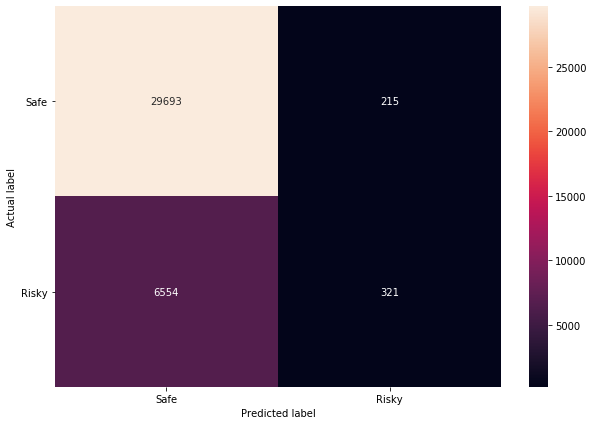

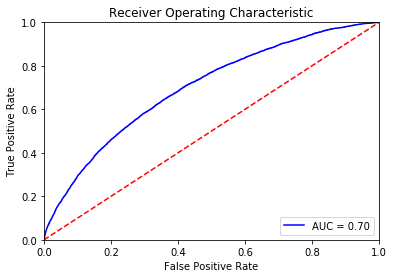

In [16]:
#DUMMY

modelRF = Model(df_dummy, model='LogisticRegression')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.8152679226816736
Precision: 0.5536193029490617
Recall: 0.06007272727272727
F1 Score: 0.10838472641385645
Cost:  132570000


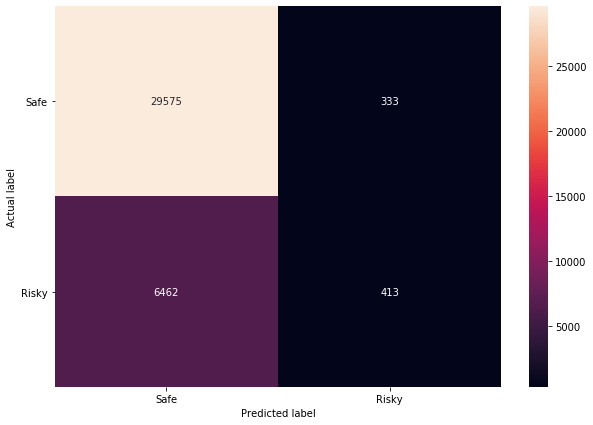

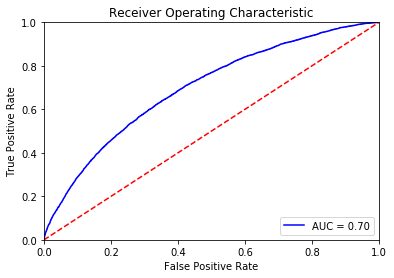

In [17]:
#Ordinal Encoded

modelReg = Model(df_base, model='LogisticRegression')

<a id='performance'></a>
# 3. Performance Metrics
<a href='#top'>back to top</a>

**Accuracy** - ratio of correctly predicted observation to the total observations. Accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. **The baseline Accuracy score is: 0.816**

Accuracy = TP+TN/TP+FP+FN+TN

**Precision** - ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all loans that labeled as safe, how many were actually safe? High precision relates to the low false positive rate. **The baseline Precision score is: 0.605**

Precision = TP/TP+FP

**Recall (Sensitivity)** - ratio of correctly predicted positive observations to the all observations in actual class - Safe. The question recall answers is: Of all the loans that were truly safe, how many did we label?  above 0.5 is good-ish. **The baseline Recall score is: 0.0496**

Recall = TP/TP+FN

**F1 score** - weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. **The baseline F1 score is: 0.0916**

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

**Receiving Operating Characteristic curve (ROC)** - It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

<a id='feature'></a>
# 4. FEATURE ENGINEERING & SELECTION
<a href='#top'>back to top</a>

In [18]:
df = load_dataset(path, index_col=0, verbose=False)

In [19]:
#assign grades to EMP_LENGTH_NUM {0: less than 1 year, 1: 1-7 years, 2: 8-10 years, 3: 10+years}
map_emp_length = {'0': '0', '1': '1', '2': '1', '3': '1',
                  '4': '1', '5': '1', '6': '1', '7': '1',
                  '8': '2', '9': '2', '10': '2', '11': '3'}

df['EMP_LENGTH_NUM'] = df['EMP_LENGTH_NUM'].astype(str).map(map_emp_length)

#information from short_emp is available in emp_length_num, so I can drop it
df = df.drop('SHORT_EMP', axis=1)

In [20]:
#simplify DTI & REVOL_UTIL - rounded to nearest 10 - made categorical
df['DTI'] = pd.Series(df['DTI']).round(-1).astype(int)
df['REVOL_UTIL'] = pd.Series(df['REVOL_UTIL']).round(-1).astype(int)
# df['TOTAL_REC_LATE_FEE'] = pd.Series(df['TOTAL_REC_LATE_FEE']).round(-1).astype(int)

In [21]:
#binarizing 'TOTAL_REC_LATE_FEE'; 1: have had late fees, 0:not late fees (at least no paid late fees)

df['TOTAL_REC_LATE_FEE'].loc[df['TOTAL_REC_LATE_FEE'] > 0] = 1
df['TOTAL_REC_LATE_FEE'].loc[df['TOTAL_REC_LATE_FEE'] == 0] = 0
df['TOTAL_REC_LATE_FEE'] = df['TOTAL_REC_LATE_FEE'].astype(object)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
df.dtypes

GRADE                    object
SUB_GRADE                object
EMP_LENGTH_NUM           object
HOME_OWNERSHIP           object
DTI                       int64
PURPOSE                  object
TERM                     object
LAST_DELINQ_NONE         object
LAST_MAJOR_DEROG_NONE    object
REVOL_UTIL                int64
TOTAL_REC_LATE_FEE       object
BAD_LOANS                object
dtype: object

In [23]:
odd_df = create_odd_ratio_features(df=df.select_dtypes(include=['object']), target='BAD_LOANS')
continuous_cols = df.select_dtypes(exclude=['object']).columns
odd_df[continuous_cols] = df[continuous_cols]
odd_df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,BAD_LOANS,GRADE_ODDS,SUB_GRADE_ODDS,EMP_LENGTH_NUM_ODDS,HOME_OWNERSHIP_ODDS,PURPOSE_ODDS,TERM_ODDS,LAST_DELINQ_NONE_ODDS,LAST_MAJOR_DEROG_NONE_ODDS,TOTAL_REC_LATE_FEE_ODDS,DTI,REVOL_UTIL
0,0,0.56,3.58,0.61,0.29,1.06,0.09,0.16,0.03,0.02,30,80
1,1,0.71,4.89,0.19,0.29,0.18,0.09,0.33,0.03,0.02,20,40
2,0,3.32,18.58,0.61,2.65,1.06,0.09,0.33,0.03,0.02,20,70
3,0,0.56,3.14,1.50,0.27,6.79,0.09,0.33,0.03,0.02,20,70
4,1,0.56,3.83,0.61,0.29,27.88,0.09,0.33,0.03,0.02,10,80


In [24]:
#create cumulative odd ratio risk feature

odd_df['TOTAL_ODDS'] = odd_df.filter(regex=('_ODDS')).sum(axis=1)

In [25]:
#some (3) features have only one count, so return NaN ()
odd_df = odd_df.dropna()

In [26]:
#select Best - here we converted all features to binary, later we will try to keep some ordinal categories
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2, f_classif

def select_KBest(df, col_names, train, test, target='Response', score_func=mutual_info_classif, k = 12):
    '''
    Prints ranked pvalues and scores of all features and returns a dataframe with only those selected features
    and the target feature. n.b: maintains the index of all rows throughout so the target feature is in the right place
    when added at the end.

    For more info on sklearn.selectKBest and parameters, visit - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest
    :param score_func: function used to calculate score and p-value, default is 'chi2'
    can be: 'chi2', 'f_classif', 'f_regression', 'mutual_info_regression' - more can be added but need to be imported
    :param k: number of features to select
    :param X: features
    :param y: target
    :return: dataframe with selected features and target
    '''
    feat_selector = SelectKBest(score_func=score_func, k=k) 
    selector = feat_selector.fit(train, test)

    feat_scores = pd.DataFrame()
    feat_scores["Score"] = np.round(selector.scores_,3)
    feat_scores["Pvalue"] = selector.pvalues_
    feat_scores["Support"] = selector.get_support()
    feat_scores["Attribute"] = col_names

    feat_scores = feat_scores.sort_values('Score', ascending=False, axis=0)
    # print(sorted_df)
    feat_scores = feat_scores.iloc[:k, :]  # get selected number of rows from ranking
    sorted_columns = feat_scores['Attribute'].values  # get column names

    print("Ranked input features:\n", feat_scores)
    
    # get columns with score above threshold
    feat_scores = feat_scores.loc[feat_scores['Score'] > 600]
    sorted_columns = feat_scores['Attribute'].values  # get column names

    new_df = df[sorted_columns] #create new DF with selected rows - created in def __init__()
    new_df[target] = df[target].values.astype(int) # add 'Response' column to new dataframe
    print("New DataFrame Columns:\n", new_df.columns)
    print('Length of new_df: \n', len(new_df))
    print(new_df.dtypes)

    
    return new_df   

In [27]:
x_train, x_test, y_train, y_test = split_and_scale(odd_df)

new_df_risk = select_KBest(odd_df, odd_df.drop('BAD_LOANS', axis=1).columns, 
                       train=x_train, test=y_train, target='BAD_LOANS', score_func=f_classif, 
                       k = len(odd_df.drop('BAD_LOANS', axis=1).columns))

Ranked input features:
        Score         Pvalue  Support                   Attribute
8   1976.407   0.000000e+00     True     TOTAL_REC_LATE_FEE_ODDS
5   1924.471   0.000000e+00     True                   TERM_ODDS
11  1190.700  3.860290e-259     True                  TOTAL_ODDS
10  1083.152  4.521994e-236     True                  REVOL_UTIL
1    976.337  3.954712e-213     True              SUB_GRADE_ODDS
0    963.972  1.798110e-210     True                  GRADE_ODDS
9    850.280  5.145930e-186     True                         DTI
2    129.548   5.408599e-30     True         EMP_LENGTH_NUM_ODDS
6      7.268   7.021159e-03     True       LAST_DELINQ_NONE_ODDS
4      1.736   1.876351e-01     True                PURPOSE_ODDS
7      0.108   7.420340e-01     True  LAST_MAJOR_DEROG_NONE_ODDS
3      0.038   8.457001e-01     True         HOME_OWNERSHIP_ODDS
New DataFrame Columns:
 Index(['TOTAL_REC_LATE_FEE_ODDS', 'TERM_ODDS', 'TOTAL_ODDS', 'REVOL_UTIL',
       'SUB_GRADE_ODDS', 'GRADE_

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
new_df_risk.head()

,TOTAL_REC_LATE_FEE_ODDS,TERM_ODDS,TOTAL_ODDS,REVOL_UTIL,SUB_GRADE_ODDS,GRADE_ODDS,DTI,BAD_LOANS
0,0.02,0.09,6.40,80,3.58,0.56,30,0
1,0.02,0.09,6.73,40,4.89,0.71,20,1
2,0.02,0.09,26.69,70,18.58,3.32,20,0
3,0.02,0.09,12.73,70,3.14,0.56,20,0
4,0.02,0.09,33.64,80,3.83,0.56,10,1


<a id='balancing'></a>
# 5. Balancing Dataset
<a href='#top'>back to top</a>

In [29]:
def cost_scorer(y_test, y_pred):
    y_test = np.array(y_test)
    diff_df = pd.DataFrame({'test': y_test, 'pred': y_pred})
    diff_df['diff'] = diff_df['test'] - diff_df['pred']
    diff_df['diff'] = diff_df['diff'].replace({255 : -1})
    counts = diff_df['diff'].value_counts()
    try:
        false_neg = counts.loc[-1]
    except:
        print('no FN')
        false_neg = 0
    try:
        false_pos = counts.loc[1]
    except:
        print('no FP')
        false_pos = 0
    cost = (false_neg * 10000) + (false_pos * 20000)
    return cost

def AUROC(y_test, y_prob, plot=True):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC: %s'%np.round(roc_auc, 3))

    if plot == True:
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show(block=False)

    return roc_auc

## 5.1. Under sampling
<a href='#top'>back to top</a>

In [30]:
#build undersampled dataset
risky_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 1]
safe_df = new_df_risk.loc[new_df_risk['BAD_LOANS'] == 0].sample(int(len(risky_df)*1.2)).reset_index().drop('index', axis=1)
undersamp_df = pd.concat([risky_df, safe_df])
undersamp_df = undersamp_df.sample(frac=1).reset_index(drop=True)
undersamp_df['BAD_LOANS'].value_counts()

0    27780
1    23150
Name: BAD_LOANS, dtype: int64

In [31]:
training_features, test_features, training_target, test_target, = split_and_scale(new_df_risk)

X = undersamp_df.drop('BAD_LOANS', axis=1)
y = undersamp_df['BAD_LOANS']
x_train, x_val, y_train, y_val = split_and_scale(undersamp_df) 


Validation Results
0.62916421231756
0.4128690169102895

Test Results
0.6892586249082456
0.5029818181818182


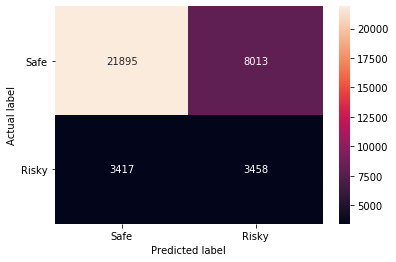

Accuracy: 0.6892586249082456
Precision: 0.3014558451747886
Recall: 0.5029818181818182
F1 Score: 0.3769759075547803
Cost:  148470000
AUC: 0.666


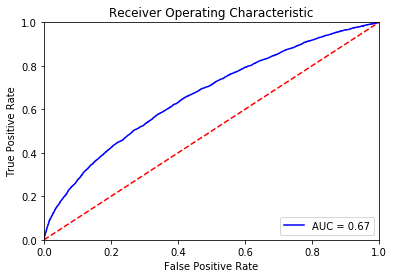

In [32]:
model = LogisticRegression()
model.fit(x_train, y_train)

print('Validation Results')
print(model.score(x_val, y_val))
print(metrics.recall_score(y_val, model.predict(x_val)))
print('\nTest Results')
print(model.score(test_features, test_target))
print(metrics.recall_score(test_target, model.predict(test_features)))

#confusion_matrix
cnf_matrix = metrics.confusion_matrix(test_target,  model.predict(test_features))
df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
hm = sns.heatmap(df_cm, annot=True, fmt='g')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

unbal_pred = model.predict(test_features)
print('Accuracy:',metrics.accuracy_score(test_target, unbal_pred))
print('Precision:',metrics.precision_score(test_target, unbal_pred))
print('Recall:',metrics.recall_score(test_target, unbal_pred))
print('F1 Score:',metrics.f1_score(test_target, unbal_pred))
print('Cost: ', cost_scorer(test_target, unbal_pred))

y_prob = model.predict_proba(test_features)[:,1]

#auroc
auc_score = AUROC(test_target, y_prob, plot=True)


## 5.2. Unchanged dataset (unbalanced)
<a href='#top'>back to top</a>

Accuracy: 0.8168447380583421
Precision: 0.5929919137466307
Recall: 0.064
F1 Score: 0.11553104896941054
Cost:  131720000


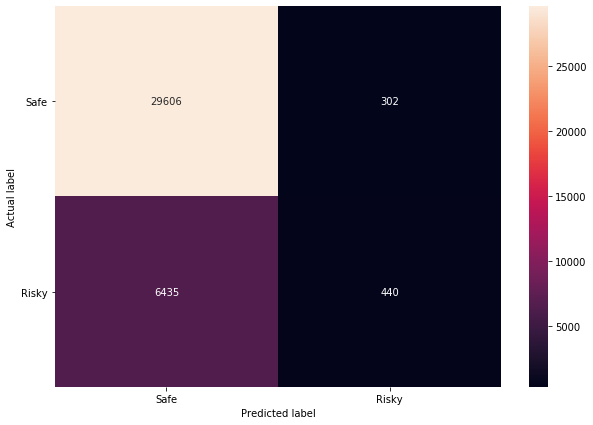

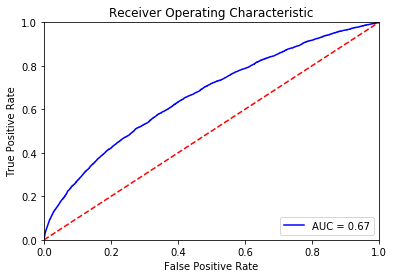

In [33]:
#model with no over or under sampling
model = Model(new_df_risk, test_size=0.3, threshold=0.5, model='LogisticRegression', target='BAD_LOANS')


## 5.3 Over sampling (SMOTE)
<a href='#top'>back to top</a>

In [34]:
##OVERSAMPLING
training_features, test_features, training_target, test_target, = split_and_scale(new_df_risk)


x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.3,
                                                  random_state=12)

sm = SMOTE(random_state=0, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Validation Results
0.6715861426130185
0.5399255275134465

Test Results
0.6705271456923035
0.5326545454545455


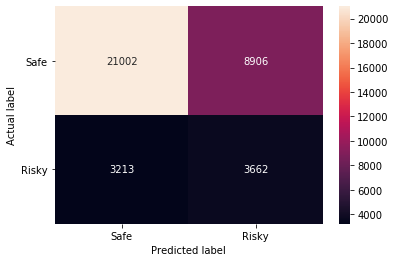

Accuracy: 0.6705271456923035
Precision: 0.2913749204328453
Recall: 0.5326545454545455
F1 Score: 0.37669083989096336
Cost:  153320000
AUC: 0.666


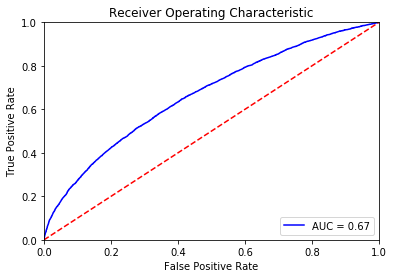

In [35]:
#ONLY FOR SMOTE
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

print('Validation Results')
print(model.score(x_val, y_val))
print(metrics.recall_score(y_val, model.predict(x_val)))
print('\nTest Results')
print(model.score(test_features, test_target))
print(metrics.recall_score(test_target, model.predict(test_features)))



#confusion_matrix
cnf_matrix = metrics.confusion_matrix(test_target,  model.predict(test_features))
df_cm = pd.DataFrame(cnf_matrix, columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
hm = sns.heatmap(df_cm, annot=True, fmt='g')
hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

unbal_pred = model.predict(test_features)
print('Accuracy:',metrics.accuracy_score(test_target, unbal_pred))
print('Precision:',metrics.precision_score(test_target, unbal_pred))
print('Recall:',metrics.recall_score(test_target, unbal_pred))
print('F1 Score:',metrics.f1_score(test_target, unbal_pred))
print('Cost: ', cost_scorer(test_target, unbal_pred))

y_prob = model.predict_proba(test_features)[:,1]

#auroc
auc_score = AUROC(test_target, y_prob, plot=True)

**Unbalanced performed best**

<a id='build'></a>
# 6. BUILD MODELS
<a href='#top'>back to top</a>

In [36]:
#make custom cost scorer for grid search
grid_cost_scorer = metrics.make_scorer(cost_scorer, greater_is_better=False, needs_proba=True)


In [37]:
x_train, x_test, y_train, y_test = split_and_scale(new_df_risk)

In [38]:
#model & parameter dictionaries for Grid Search
seed = 3
models = {
    'RF': RandomForestClassifier(),
    'neighbours': KNeighborsClassifier(),
    'logistic': LogisticRegression(),
    'mlp': MLPClassifier(),
}
params = {
    'RF': {
        'max_depth': [4, 8],
        'n_estimators': [100, 200],
        'max_features': ['auto', 'log2'],
        'bootstrap': [True],
        'criterion': ['gini'],
        'oob_score': [False]
    },
    'neighbours': {
        'n_neighbors': np.arange(3, 15),
        'weights': ['uniform', 'distance'],
        'algorithm': ['kd_tree', 'brute']
    },
    'mlp': {
        'solver': ['adam', 'sgd'],
        'max_iter': [500,1000,1500],
        'alpha': 10.0 ** -np.arange(1, 10, 3),
        'hidden_layer_sizes': np.arange(10, 16,2)
    },
    'logistic': {
        'C':np.logspace(-3,3,4), 
        'penalty':['l1','l2'],
        'random_state' : [seed],
      },
    'svc': {
         'kernel': ['rbf'], 
         'gamma': [1e-3, 1e-4],
         'C': [500, 1000],
         'probability': [True]
    }
}

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if there is a class imbalance.

**NOTE**: No need to run this (slow), the best estimators are already saved below

RF
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.1min finished


best estimator is: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
best score are: 0.0
best parameters are: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100, 'oob_score': False}


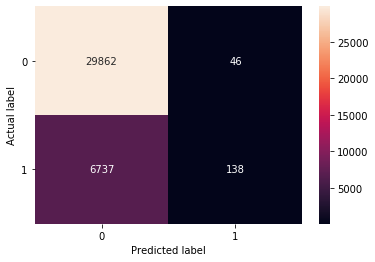

Accuracy: 0.8155941603458119
Precision: 0.75
Recall: 0.020072727272727273
F1 Score: 0.039099022524436894
cost:  135200000
AUC: 0.688


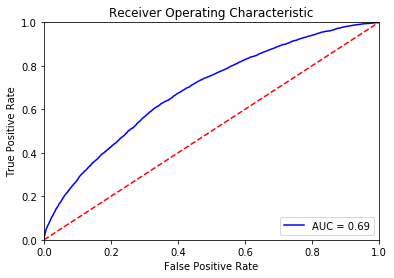

neighbours
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN
no FN


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 63.3min finished


best estimator is: KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')
best score are: -4158000.0
best parameters are: {'algorithm': 'kd_tree', 'n_neighbors': 14, 'weights': 'uniform'}


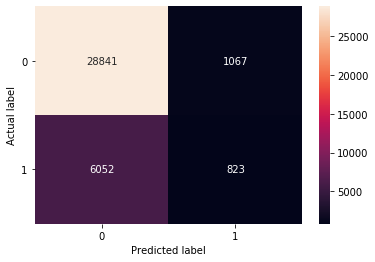

Accuracy: 0.8064595057499389
Precision: 0.4354497354497355
Recall: 0.1197090909090909
F1 Score: 0.18779235596120933
cost:  131710000
AUC: 0.643


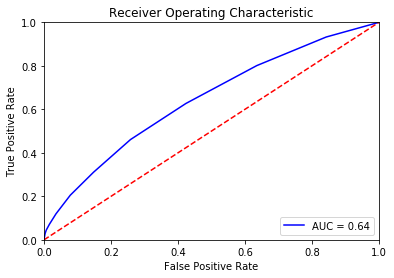

logistic
Fitting 5 folds for each of 8 candidates, totalling 40 fits
no FN
no FP
no FN
no FP


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


no FN
no FP
no FN
no FP
no FN
no FP


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
best estimator is: LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
best score are: 0.0
best parameters are: {'C': 0.001, 'penalty': 'l2', 'random_state': 3}


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.1s finished


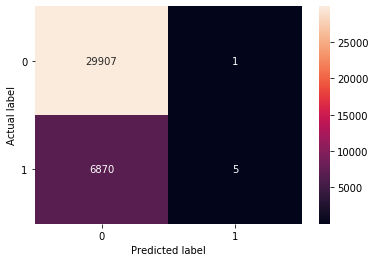

Accuracy: 0.8132017508087975
Precision: 0.8333333333333334
Recall: 0.0007272727272727272
F1 Score: 0.0014532771399505887
cost:  137410000
AUC: 0.661


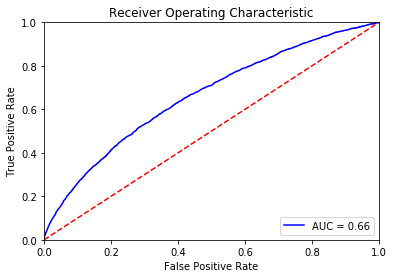

mlp
Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no F

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 20.8min finished


best estimator is: MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
best score are: 0.0
best parameters are: {'alpha': 0.1, 'hidden_layer_sizes': 10, 'max_iter': 500, 'solver': 'adam'}


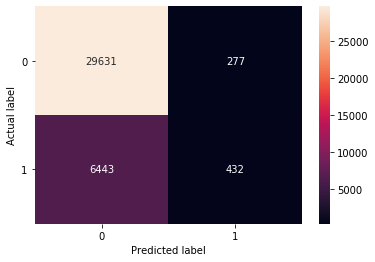

Accuracy: 0.8173069080825381
Precision: 0.609308885754584
Recall: 0.06283636363636363
F1 Score: 0.11392405063291139
cost:  131630000
AUC: 0.668


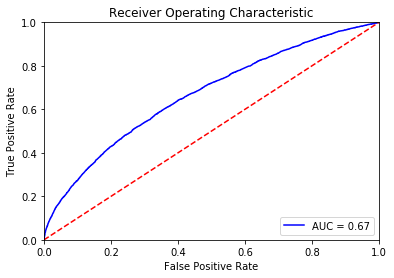

In [39]:
threshold = 0.5
dict_best = {}
for name in models.keys():
    print(name)
    est = models[name]
    est_params = params[name]
    model = GridSearchCV(estimator=est, param_grid=est_params, cv=5,
                        scoring=grid_cost_scorer, verbose=1) #can also set scoring='precision_micro'
    model.fit(x_train, y_train)
    print("best estimator is: {}".format(model.best_estimator_))
    print("best score are: {}".format(model.best_score_))
    print("best parameters are: {}".format(model.best_params_))
    best_estimator = model.best_estimator_
    dict_best[name] = best_estimator
    
    y_prob = model.predict_proba(x_test)[:, 1]

    predictions_df = pd.DataFrame({'y_prob': y_prob, 'y_test': y_test})
    predictions_df.to_csv('predict_proba_%s_%s.csv'%(name, threshold))

    y_pred = [0 if v < threshold else 1 for v in y_prob]

    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cnf_matrix)  # , columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
    hm = sns.heatmap(df_cm, annot=True, fmt='g')
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show(block=False)

    print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
    print('Precision:', metrics.precision_score(y_test, y_pred))
    print('Recall:', metrics.recall_score(y_test, y_pred))
    print('F1 Score:', metrics.f1_score(y_test, y_pred))
        
    #calculate cost
    y_test = np.array(y_test)
    diff_df = pd.DataFrame({'test': y_test, 'pred': y_pred})
    diff_df['diff'] = diff_df['test'] - diff_df['pred']
    diff_df['diff'] = diff_df['diff'].replace({255 : -1})
    counts = diff_df['diff'].value_counts()
    try:
        false_neg = counts.loc[-1]
    except:
        print('no FN')
        false_neg = 0
    try:
        false_pos = counts.loc[1]
    except:
        print('no FP')
        false_pos = 0
        
    cost = (false_neg * 10000) + (false_pos * 20000)
    
    print('cost: ', cost)

    filename = '%s_cost_.sav'%name
    pickle.dump(best_estimator, open(filename, 'wb'))
    
    # Save to file in the current working directory
    pkl_filename = '%s_cost_.pkl'%name
    with open(pkl_filename, 'wb') as file:
        pickle.dump(best_estimator, file)
    
    auc = AUROC(test_target, y_prob, plot=True)
    


In [40]:
#best parameters for each classifier
dict_best

{'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=4, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'neighbours': KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                      weights='uniform'),
 'logistic': LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
   

In [41]:
#create a smaller dataset for SVC - otherwise it takes too long to train
svc_sample = undersamp_df.sample(10000)

x_train_svc, x_test_svc, y_train_svc, y_test_svc = split_and_scale(svc_sample)

svc
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP
no FN
no FP


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


best estimator is: SVC(C=500, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
best score are: 0.0
best parameters are: {'C': 500, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}


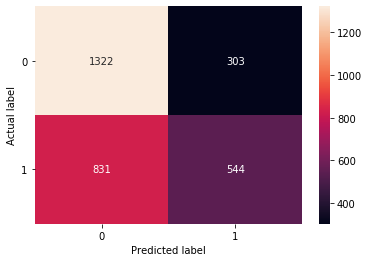

Accuracy: 0.622
Precision: 0.6422668240850059
Recall: 0.3956363636363636
F1 Score: 0.4896489648964896
cost:  19650000


In [45]:
seed = 3
models = {
    'svc':SVC()
}
threshold = 0.5
dict_best_SVC = {}
for name in models.keys():
    print(name)
    est = models[name]
    est_params = params[name]
    model = GridSearchCV(estimator=est, param_grid=est_params, cv=5,
                        scoring=grid_cost_scorer, verbose=1) #can also set scoring='precision_micro'
    model.fit(x_train_svc, y_train_svc)
    print("best estimator is: {}".format(model.best_estimator_))
    print("best score are: {}".format(model.best_score_))
    print("best parameters are: {}".format(model.best_params_))
    best_estimator = model.best_estimator_
    dict_best_SVC[name] = best_estimator
    
    y_prob = model.predict_proba(x_test_svc)[:, 1]

    predictions_df = pd.DataFrame({'y_prob': y_prob, 'y_test': y_test_svc})
    predictions_df.to_csv('predict_proba_%s_%s.csv'%(name, threshold))

    y_pred = [0 if v < threshold else 1 for v in y_prob]

    cnf_matrix = metrics.confusion_matrix(y_test_svc, y_pred)
    df_cm = pd.DataFrame(cnf_matrix)  # , columns=['Safe', 'Risky'], index=['Safe', 'Risky'])
    hm = sns.heatmap(df_cm, annot=True, fmt='g')
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show(block=False)

    print('Accuracy:', metrics.accuracy_score(y_test_svc, y_pred))
    print('Precision:', metrics.precision_score(y_test_svc, y_pred))
    print('Recall:', metrics.recall_score(y_test_svc, y_pred))
    print('F1 Score:', metrics.f1_score(y_test_svc, y_pred))
        
    #calculate cost
    y_test_svc = np.array(y_test_svc)
    diff_df = pd.DataFrame({'test': y_test_svc, 'pred': y_pred})
    diff_df['diff'] = diff_df['test'] - diff_df['pred']
    diff_df['diff'] = diff_df['diff'].replace({255 : -1})
    counts = diff_df['diff'].value_counts()
    try:
        false_neg = counts.loc[-1]
    except:
        print('no FN')
        false_neg = 0
    try:
        false_pos = counts.loc[1]
    except:
        print('no FP')
        false_pos = 0
        
    cost = (false_neg * 10000) + (false_pos * 20000)
    
    print('cost: ', cost)

    filename = '%s_cost_.sav'%name
    pickle.dump(best_estimator, open(filename, 'wb'))
    
    # Save to file in the current working directory
    pkl_filename = '%s_cost_.pkl'%name
    with open(pkl_filename, 'wb') as file:
        pickle.dump(best_estimator, file)
    

In [46]:
dict_best_SVC

{'svc': SVC(C=500, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False)}

<a id='train'></a>
# 7. Train Models
<a href='#top'>back to top</a>

Now that we have the best estimators, we can train the models on the whole dataset. These models will be used to make predictions on new data in the application.

**Note** that we have two sets of optimal models; those optmizied of the custom cost_scorer and those optimized on 'precision_recall'.

**Also note** that SVC will be trained on a smaller dataset (sampled from the undersampled_df dataframe) to reduce the training time. 

<a id='precision'></a>
## 7.1. Precision Micro
<a href='#top'>back to top</a>

In [ ]:
#create training % testing data - full dataset
X = new_df_risk.drop('BAD_LOANS', axis=1)
y = new_df_risk['BAD_LOANS']

In [ ]:
#MLP
model = MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=12, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('mlp_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'mlp_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#Logistic Regression
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=3, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('logistic_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'logistic_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#KNeighbours
model = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=14, p=2,
           weights='uniform')
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('neighbours_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'neighbours_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#RF
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('RF_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'RF_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
svc_sample = undersamp_df.sample(10000)
#create training % testing data - full dataset
Xsamp = svc_sample.drop('BAD_LOANS', axis=1)
ysamp = svc_sample['BAD_LOANS']

In [ ]:
#SVC

model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(Xsamp,ysamp)

##ONLY used if we want to make predictions - not necessary here since model is trained on whole dataset
# y_pred = model.predict(test_features)

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target}).to_csv('svc_predictions_precision.csv')

# Save to file in the current working directory
pkl_filename = 'svc_precision_micro_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

<a id='cost'></a>
## 7.2. Cost Scorer 
<a href='#top'>back to top</a>

In [ ]:
#MLP
model = MLPClassifier(activation='relu', alpha=1e-07, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=12, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# y_prob = model.predict_proba(test_features)[:,1]

# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('mlp_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'mlp_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#LogisticRegression
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=3, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('logistic_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'logistic_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#KNeighbours
model = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')
model.fit(X,y)

# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('neighbours_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'neighbours_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#RF
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X,y)


# y_pred = model.predict(test_features)

# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('RF_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'RF_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
#SVC


model = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
model.fit(Xsamp,ysamp)


# y_pred = model.predict(test_features)
# y_prob = model.predict_proba(test_features)[:,1]


# prediction = pd.DataFrame({'y_pred': y_pred, 'y_test':test_target, 'y_prob': y_prob}).to_csv('svc_predictions_cost.csv')

# Save to file in the current working directory
pkl_filename = 'svc_cost_analyse.pkl'  #%name
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

<a id='application'></a>
# 8. Application
<a href='#top'>back to top</a>


<a href='http://jkuypers.pythonanywhere.com/'>Visit OutLending Application</a>